# Comparing 2025-Era Small LLMs and HMMs for Time Series Forecasting

**Group Members:** Zeyuan Ding (zd2466@nyu.edu), Keyu Hong (kh4300@nyu.edu)

---

### Research Question
Can new-generation small LLMs, when treating numerical sequences as text tokens, outperform HMMs in short- and medium-term air quality forecasting?

### Dataset
Beijing PM2.5 Air Quality Dataset (2010-2014) - hourly PM2.5 concentrations and meteorological variables

In [1]:
# !pip install hmmlearn
# !pip install transformers
# !pip install torch

## 1. Environment Setup and Library Imports

In [2]:
# Core data manipulation and numerical computing
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Machine learning and preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Hidden Markov Model implementation
from hmmlearn import hmm

# Deep learning frameworks for LLM
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)

# Utility imports
from datetime import datetime, timedelta
from typing import List, Tuple, Dict
import json
from tqdm import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Data Loading and Preprocessing

In [3]:
# Load the Beijing PM2.5 dataset
# Note: Download from https://archive.ics.uci.edu/dataset/381/beijing+pm2+5+data
# Expected file: PRSA_data_2010.1.1-2014.12.31.csv

def load_and_preprocess_data(filepath: str) -> pd.DataFrame:
    """
    Load and perform initial preprocessing on the Beijing PM2.5 dataset.

    Args:
        filepath: Path to the CSV file

    Returns:
        Preprocessed DataFrame with datetime index and cleaned features
    """
    # Read the dataset
    df = pd.read_csv(filepath)

    # Display basic information
    print("Dataset shape:", df.shape)
    print("\nColumn names:")
    print(df.columns.tolist())
    print("\nFirst few rows:")
    print(df.head())

    # Create datetime index from year, month, day, hour columns
    df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
    df.set_index('datetime', inplace=True)

    # Drop redundant columns
    columns_to_drop = ['No', 'year', 'month', 'day', 'hour']
    df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    # Display missing value statistics
    print("\nMissing values per column:")
    print(df.isnull().sum())
    print(f"\nTotal missing values: {df.isnull().sum().sum()}")
    print(f"Percentage missing: {df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100:.2f}%")

    return df

# Load the data
# Update this path to match your local file location
data_path = 'PRSA_data_2010.1.1-2014.12.31.csv'
df_raw = load_and_preprocess_data(data_path)

Dataset shape: (43824, 13)

Column names:
['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir']

First few rows:
   No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
0   1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
1   2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2   3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   0   0
3   4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   0   0
4   5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   0   0

Missing values per column:
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

Total missing values: 2067
Percentage missing: 0.59%


In [4]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Handle missing values and outliers in the dataset.

    Strategy:
    - Forward fill for short gaps (< 3 hours)
    - Linear interpolation for medium gaps (3-24 hours)
    - Drop remaining NaN values

    Args:
        df: Raw DataFrame with missing values

    Returns:
        Cleaned DataFrame
    """
    df_clean = df.copy()

    # Forward fill for short gaps
    df_clean = df_clean.fillna(method='ffill', limit=2)

    # Interpolate for medium gaps
    df_clean = df_clean.interpolate(method='linear', limit=24)

    # Drop remaining missing values
    df_clean.dropna(inplace=True)

    print(f"Data shape after cleaning: {df_clean.shape}")
    print(f"Remaining missing values: {df_clean.isnull().sum().sum()}")

    return df_clean

df_clean = clean_data(df_raw)

Data shape after cleaning: (42979, 8)
Remaining missing values: 0


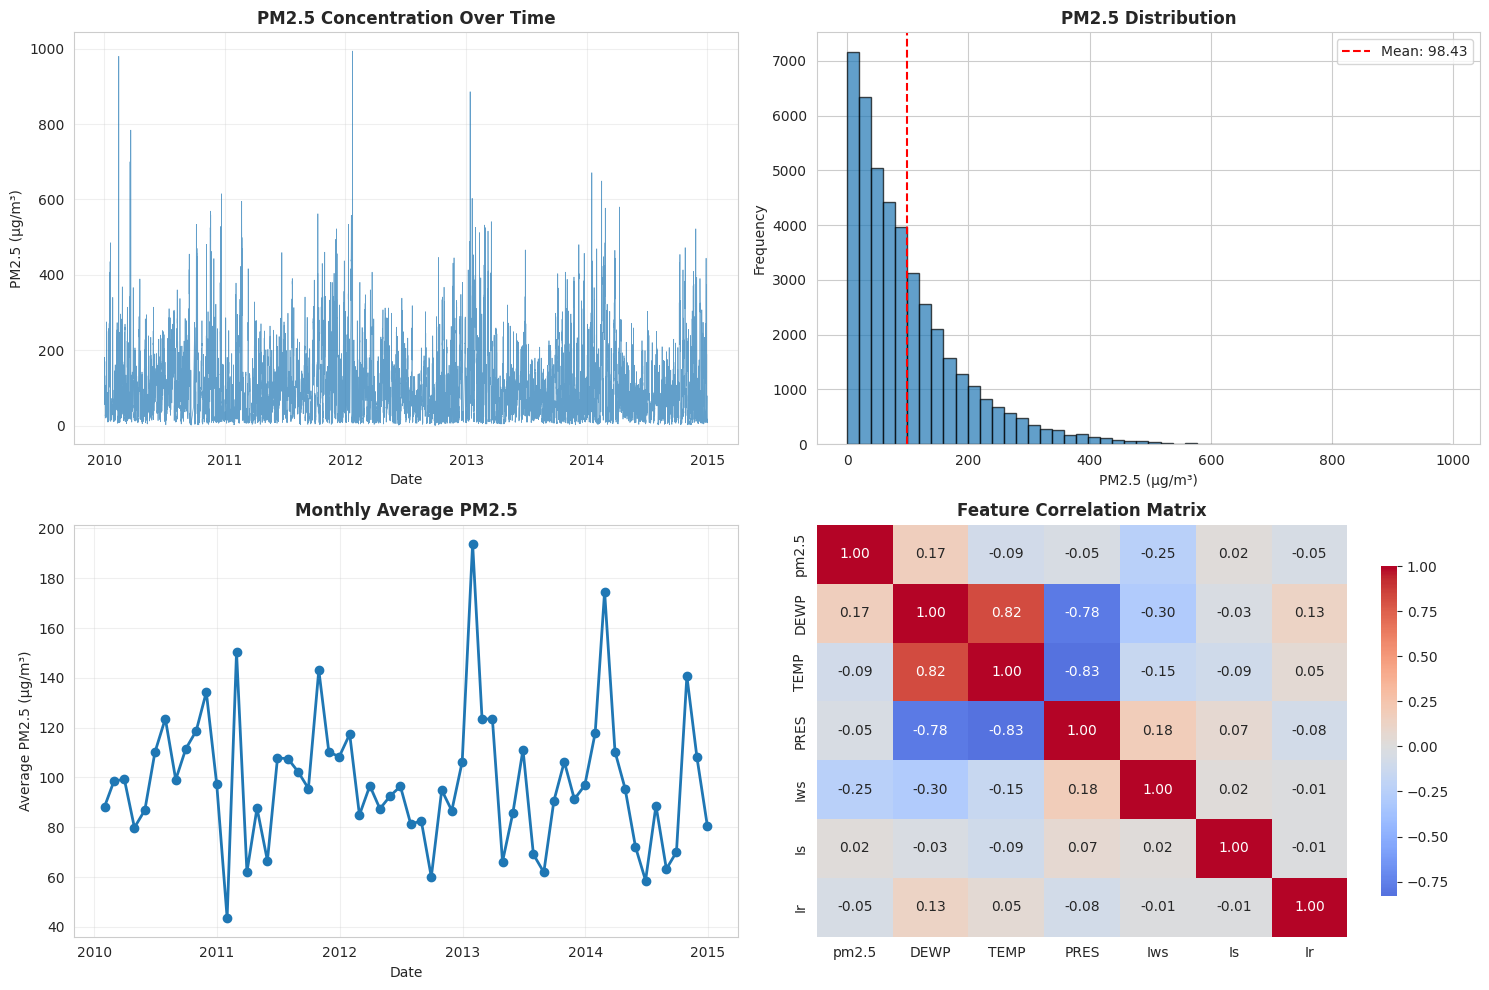


Statistical Summary:
              pm2.5          DEWP          TEMP          PRES           Iws  \
count  42979.000000  42979.000000  42979.000000  42979.000000  42979.000000   
mean      98.431666      1.835780     12.475488   1016.409433     23.923056   
std       91.616942     14.434033     12.173291     10.290751     49.937185   
min        0.000000    -40.000000    -19.000000    991.000000      0.450000   
25%       29.000000    -10.000000      2.000000   1008.000000      1.790000   
50%       73.000000      2.000000     14.000000   1016.000000      5.370000   
75%      136.000000     15.000000     23.000000   1025.000000     21.910000   
max      994.000000     28.000000     42.000000   1046.000000    585.600000   

                 Is            Ir  
count  42979.000000  42979.000000  
mean       0.053770      0.198492  
std        0.767777      1.429235  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.0

In [5]:
# Exploratory Data Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# PM2.5 time series
axes[0, 0].plot(df_clean.index, df_clean['pm2.5'], linewidth=0.5, alpha=0.7)
axes[0, 0].set_title('PM2.5 Concentration Over Time', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('PM2.5 (μg/m³)')
axes[0, 0].grid(True, alpha=0.3)

# PM2.5 distribution
axes[0, 1].hist(df_clean['pm2.5'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('PM2.5 Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('PM2.5 (μg/m³)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df_clean['pm2.5'].mean(), color='red', linestyle='--',
                   label=f'Mean: {df_clean["pm2.5"].mean():.2f}')
axes[0, 1].legend()

# Monthly average PM2.5
monthly_avg = df_clean['pm2.5'].resample('M').mean()
axes[1, 0].plot(monthly_avg.index, monthly_avg.values, marker='o', linewidth=2)
axes[1, 0].set_title('Monthly Average PM2.5', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Average PM2.5 (μg/m³)')
axes[1, 0].grid(True, alpha=0.3)

# Correlation heatmap for numerical features
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
correlation_matrix = df_clean[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, ax=axes[1, 1], cbar_kws={'shrink': 0.8})
axes[1, 1].set_title('Feature Correlation Matrix', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('eda_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# Display statistical summary
print("\nStatistical Summary:")
print(df_clean.describe())

## 3. Feature Engineering and Data Preparation

In [6]:
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Engineer temporal and statistical features from the raw data.

    Features include:
    - Temporal: hour of day, day of week, month, season
    - Lag features: previous 1, 3, 6, 12, 24 hours
    - Rolling statistics: mean, std, min, max over windows

    Args:
        df: Cleaned DataFrame

    Returns:
        DataFrame with engineered features
    """
    df_features = df.copy()

    # Temporal features
    df_features['hour'] = df_features.index.hour
    df_features['day_of_week'] = df_features.index.dayofweek
    df_features['month'] = df_features.index.month
    df_features['season'] = (df_features.index.month % 12 + 3) // 3  # 1=winter, 2=spring, 3=summer, 4=fall

    # Cyclical encoding for temporal features
    df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
    df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)
    df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
    df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)

    # Lag features for PM2.5
    for lag in [1, 3, 6, 12, 24]:
        df_features[f'pm2.5_lag_{lag}'] = df_features['pm2.5'].shift(lag)

    # Rolling window statistics
    for window in [6, 12, 24]:
        df_features[f'pm2.5_rolling_mean_{window}'] = df_features['pm2.5'].rolling(window=window).mean()
        df_features[f'pm2.5_rolling_std_{window}'] = df_features['pm2.5'].rolling(window=window).std()
        df_features[f'pm2.5_rolling_min_{window}'] = df_features['pm2.5'].rolling(window=window).min()
        df_features[f'pm2.5_rolling_max_{window}'] = df_features['pm2.5'].rolling(window=window).max()

    # Drop rows with NaN values created by lagging and rolling
    df_features.dropna(inplace=True)

    print(f"Feature engineering complete. Shape: {df_features.shape}")
    print(f"Number of features: {len(df_features.columns)}")

    return df_features

df_features = create_features(df_clean)

Feature engineering complete. Shape: (42955, 33)
Number of features: 33


In [7]:
def create_train_test_split(df: pd.DataFrame, test_size: float = 0.2) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Create temporal train-test split for time series data.

    Args:
        df: Feature-engineered DataFrame
        test_size: Proportion of data to use for testing

    Returns:
        Tuple of (train_df, test_df)
    """
    split_idx = int(len(df) * (1 - test_size))

    train_df = df.iloc[:split_idx].copy()
    test_df = df.iloc[split_idx:].copy()

    print(f"Train set: {train_df.shape[0]} samples ({train_df.index[0]} to {train_df.index[-1]})")
    print(f"Test set: {test_df.shape[0]} samples ({test_df.index[0]} to {test_df.index[-1]})")

    return train_df, test_df

train_df, test_df = create_train_test_split(df_features, test_size=0.2)

Train set: 34364 samples (2010-01-03 00:00:00 to 2014-01-08 00:00:00)
Test set: 8591 samples (2014-01-08 01:00:00 to 2014-12-31 23:00:00)


## 4. Hidden Markov Model Implementation

In [8]:
class PM25HMM:
    """
    Gaussian Hidden Markov Model for PM2.5 forecasting.

    The model identifies latent pollution regimes and forecasts future PM2.5 levels
    through learned state transitions and emission probabilities.
    """

    def __init__(self, n_components: int = 5, n_iter: int = 100, random_state: int = 42):
        """
        Initialize the HMM.

        Args:
            n_components: Number of hidden states (pollution regimes)
            n_iter: Number of EM iterations for training
            random_state: Random seed for reproducibility
        """
        self.n_components = n_components
        self.model = hmm.GaussianHMM(
            n_components=n_components,
            covariance_type="full",
            n_iter=n_iter,
            random_state=random_state
        )
        self.scaler = StandardScaler()
        self.is_fitted = False

    def prepare_data(self, df: pd.DataFrame, feature_cols: List[str]) -> np.ndarray:
        """
        Prepare and scale features for HMM training.

        Args:
            df: DataFrame with features
            feature_cols: List of feature column names

        Returns:
            Scaled feature matrix
        """
        X = df[feature_cols].values
        return X

    def fit(self, train_df: pd.DataFrame, feature_cols: List[str]) -> 'PM25HMM':
        """
        Train the HMM on training data.

        Args:
            train_df: Training DataFrame
            feature_cols: List of feature columns to use

        Returns:
            Self (fitted model)
        """
        X_train = self.prepare_data(train_df, feature_cols)
        X_train_scaled = self.scaler.fit_transform(X_train)

        print(f"Training HMM with {self.n_components} hidden states...")
        self.model.fit(X_train_scaled)
        self.is_fitted = True

        # Analyze learned states
        hidden_states = self.model.predict(X_train_scaled)
        print(f"\nHidden state distribution in training data:")
        unique, counts = np.unique(hidden_states, return_counts=True)
        for state, count in zip(unique, counts):
            print(f"  State {state}: {count} ({count/len(hidden_states)*100:.2f}%)")

        return self

    def predict_one_step(self, history_df: pd.DataFrame, feature_cols: List[str]) -> float:
        """
        Predict PM2.5 for the next time step.

        Args:
            history_df: Historical data DataFrame
            feature_cols: Feature columns to use

        Returns:
            Predicted PM2.5 value
        """
        if not self.is_fitted:
            raise ValueError("Model must be fitted before prediction")

        X_history = self.prepare_data(history_df, feature_cols)
        X_history_scaled = self.scaler.transform(X_history)

        # Get the most likely hidden state sequence
        hidden_states = self.model.predict(X_history_scaled)
        current_state = hidden_states[-1]

        # Predict next state based on transition probabilities
        next_state_probs = self.model.transmat_[current_state]
        next_state = np.argmax(next_state_probs)

        # Get emission mean for the next state (using first feature as PM2.5)
        next_pm25 = self.model.means_[next_state][0] * self.scaler.scale_[0] + self.scaler.mean_[0]

        return next_pm25

    def predict_multi_step(self, history_df: pd.DataFrame, feature_cols: List[str],
                          steps: int = 6) -> List[float]:
        """
        Predict PM2.5 for multiple future time steps.

        Args:
            history_df: Historical data DataFrame
            feature_cols: Feature columns to use
            steps: Number of future steps to predict

        Returns:
            List of predicted PM2.5 values
        """
        predictions = []
        current_history = history_df.copy()

        for _ in range(steps):
            pred = self.predict_one_step(current_history, feature_cols)
            predictions.append(pred)

            # Note: In practice, we would need to update the history with the prediction
            # For simplicity, we're using the last observed state transitions

        return predictions

# Define features to use for HMM
hmm_feature_cols = ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']

In [9]:
# Train HMM model
print("=" * 60)
print("Training Hidden Markov Model")
print("=" * 60)

hmm_model = PM25HMM(n_components=5, n_iter=100)
hmm_model.fit(train_df, hmm_feature_cols)

print("\nHMM training complete!")

Training Hidden Markov Model
Training HMM with 5 hidden states...


Model is not converging.  Current: 280574.96765859134 is not greater than 638705.2765842926. Delta is -358130.3089257013



Hidden state distribution in training data:
  State 0: 100 (0.29%)
  State 1: 6723 (19.56%)
  State 2: 329 (0.96%)
  State 3: 1519 (4.42%)
  State 4: 25693 (74.77%)

HMM training complete!


## 5. Large Language Model Implementation

In [10]:
class TimeSeriesTokenizer:
    """
    Tokenizer for converting numerical time series into discrete tokens for LLM input.

    Strategy:
    - Quantize continuous PM2.5 values into discrete bins
    - Create vocabulary of tokens representing value ranges
    - Format sequences with special tokens for temporal structure
    """

    def __init__(self, n_bins: int = 100, value_range: Tuple[float, float] = None):
        """
        Initialize the tokenizer.

        Args:
            n_bins: Number of discrete bins for quantization
            value_range: (min, max) range for binning, or None to compute from data
        """
        self.n_bins = n_bins
        self.value_range = value_range
        self.bins = None
        self.token_to_value = {}
        self.value_to_token = {}

    def fit(self, values: np.ndarray) -> 'TimeSeriesTokenizer':
        """
        Fit the tokenizer to the data range.

        Args:
            values: Array of PM2.5 values

        Returns:
            Self (fitted tokenizer)
        """
        if self.value_range is None:
            min_val = np.floor(values.min())
            max_val = np.ceil(values.max())
            self.value_range = (min_val, max_val)

        # Create bins
        self.bins = np.linspace(self.value_range[0], self.value_range[1], self.n_bins + 1)

        # Create token mappings
        for i in range(self.n_bins):
            token = f"<PM25_{i}>"
            bin_center = (self.bins[i] + self.bins[i+1]) / 2
            self.token_to_value[token] = bin_center
            self.value_to_token[i] = token

        print(f"Tokenizer fitted: {self.n_bins} bins from {self.value_range[0]:.1f} to {self.value_range[1]:.1f}")
        return self

    def encode(self, values: np.ndarray) -> List[str]:
        """
        Convert numerical values to tokens.

        Args:
            values: Array of PM2.5 values

        Returns:
            List of token strings
        """
        bin_indices = np.digitize(values, self.bins) - 1
        bin_indices = np.clip(bin_indices, 0, self.n_bins - 1)
        tokens = [self.value_to_token[idx] for idx in bin_indices]
        return tokens

    def decode(self, tokens: List[str]) -> np.ndarray:
        """
        Convert tokens back to numerical values.

        Args:
            tokens: List of token strings

        Returns:
            Array of PM2.5 values
        """
        values = [self.token_to_value.get(token, self.value_range[0]) for token in tokens]
        return np.array(values)

    def create_sequence(self, values: np.ndarray, context_length: int = 24) -> str:
        """
        Create a formatted sequence string for LLM input.

        Args:
            values: Array of PM2.5 values
            context_length: Number of past values to include

        Returns:
            Formatted string with tokens
        """
        tokens = self.encode(values[-context_length:])
        sequence = " ".join(tokens)
        return sequence

In [11]:
class PM25TimeSeriesDataset(Dataset):
    """
    PyTorch Dataset for time series forecasting with LLMs.

    Creates sliding windows of tokenized sequences for autoregressive training.
    """

    def __init__(self, df: pd.DataFrame, tokenizer: TimeSeriesTokenizer,
                 context_length: int = 24, target_length: int = 1):
        """
        Initialize the dataset.

        Args:
            df: DataFrame with PM2.5 values
            tokenizer: Fitted TimeSeriesTokenizer
            context_length: Number of past time steps to use as context
            target_length: Number of future time steps to predict
        """
        self.values = df['pm2.5'].values
        self.tokenizer = tokenizer
        self.context_length = context_length
        self.target_length = target_length

        # Create all valid sequences
        self.sequences = []
        total_length = context_length + target_length

        for i in range(len(self.values) - total_length + 1):
            sequence = self.values[i:i + total_length]
            self.sequences.append(sequence)

        print(f"Created {len(self.sequences)} sequences (context: {context_length}, target: {target_length})")

    def __len__(self) -> int:
        return len(self.sequences)

    def __getitem__(self, idx: int) -> Dict[str, str]:
        """
        Get a single sequence for training.

        Args:
            idx: Sequence index

        Returns:
            Dictionary with 'text' key containing the full tokenized sequence
        """
        sequence = self.sequences[idx]
        tokens = self.tokenizer.encode(sequence)
        text = " ".join(tokens)

        return {"text": text}

In [12]:
class PM25LLMForecaster:
    """
    Wrapper class for fine-tuning and using small LLMs for PM2.5 forecasting.
    FIXED: Loads model in float32 to prevent gradient scaling errors.
    """

    def __init__(self, model_name: str = "Qwen/Qwen3-0.6B",
                 n_bins: int = 100, context_length: int = 24):
        self.model_name = model_name
        self.context_length = context_length
        self.device = device
        self.n_bins = n_bins

        # Initialize tokenizer
        self.ts_tokenizer = TimeSeriesTokenizer(n_bins=n_bins)

        print(f"Loading model: {model_name}")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        # Add Custom Tokens
        new_tokens = [f"<PM25_{i}>" for i in range(n_bins)]
        self.tokenizer.add_tokens(new_tokens)

        # --- FIX: Load Model in Float32 ---
        # We load in float32 so the Trainer can safely manage mixed precision (fp16)
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            trust_remote_code=True,
            torch_dtype=torch.float32
        )

        self.model.resize_token_embeddings(len(self.tokenizer))
        self.model.to(self.device)

    def prepare_dataset(self, train_df: pd.DataFrame, val_df: pd.DataFrame = None):
        self.ts_tokenizer.fit(train_df['pm2.5'].values)

        self.train_dataset = PM25TimeSeriesDataset(
            train_df, self.ts_tokenizer,
            context_length=self.context_length, target_length=1
        )

        if val_df is not None:
            self.val_dataset = PM25TimeSeriesDataset(
                val_df, self.ts_tokenizer,
                context_length=self.context_length, target_length=1
            )
        else:
            self.val_dataset = None

    def fine_tune(self, output_dir: str, num_epochs: int = 3, batch_size: int = 4, learning_rate: float = 2e-5):
        print(f"Starting fine-tuning for {num_epochs} epochs...")

        # Tokenize datasets
        tokenized_train = [self.tokenizer(x['text'], truncation=True, padding="max_length", max_length=64, return_tensors="pt") for x in self.train_dataset]
        tokenized_train = [{k: v.squeeze() for k, v in item.items()} for item in tokenized_train]

        tokenized_val = None
        if self.val_dataset:
            tokenized_val = [self.tokenizer(x['text'], truncation=True, padding="max_length", max_length=64, return_tensors="pt") for x in self.val_dataset]
            tokenized_val = [{k: v.squeeze() for k, v in item.items()} for item in tokenized_val]

        args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=num_epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            learning_rate=learning_rate,
            weight_decay=0.01,
            logging_steps=10,
            eval_strategy="epoch" if tokenized_val else "no",
            save_strategy="epoch",
            fp16=torch.cuda.is_available(), # Trainer will handle the fp16 casting safely now
            remove_unused_columns=False
        )

        trainer = Trainer(
            model=self.model,
            args=args,
            train_dataset=tokenized_train,
            eval_dataset=tokenized_val,
            data_collator=DataCollatorForLanguageModeling(tokenizer=self.tokenizer, mlm=False),
        )

        trainer.train()
        trainer.save_model(output_dir)
        self.tokenizer.save_pretrained(output_dir)
        print("Training complete.")

    def predict_one_step(self, history: np.ndarray) -> float:
        self.model.eval()
        input_text = self.ts_tokenizer.create_sequence(history, self.context_length)
        inputs = self.tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=1,
                num_return_sequences=1,
                do_sample=False,
                pad_token_id=self.tokenizer.pad_token_id
            )

        generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=False)

        import re
        matches = re.findall(r"<PM25_\d+>", generated_text)
        if matches:
            new_token = matches[-1]
            try:
                prediction = self.ts_tokenizer.decode([new_token])[0]
            except:
                prediction = np.mean(history)
        else:
            prediction = np.mean(history)

        return prediction

In [13]:
# # Note: This cell demonstrates the LLM setup but is commented out to avoid long training times
# # Uncomment and run to actually train the LLM


# # Initialize LLM forecaster
# llm_forecaster = PM25LLMForecaster(
#     model_name="Qwen/Qwen3-0.6B",  # Or "Qwen/Qwen2.5-1.5B", "meta-llama/Llama-3.2-1B"
#     n_bins=100,
#     context_length=24
# )
# '''
# # Split training data for validation
# val_split = int(len(train_df) * 0.9)
# train_subset = train_df.iloc[:val_split]
# val_subset = train_df.iloc[val_split:]

# # Prepare datasets
# llm_forecaster.prepare_dataset(train_subset, val_subset)

# # Fine-tune the model
# llm_forecaster.fine_tune(
#     output_dir="./llm_pm25_model",
#     num_epochs=3,
#     batch_size=4,
#     learning_rate=2e-5
# )
# '''

# print("LLM implementation complete (training commented out for demonstration)")
# print("Uncomment the code above to actually train the LLM model")

## 6. Evaluation Metrics Implementation

In [14]:
class ForecastingMetrics:
    """
    Comprehensive evaluation metrics for time series forecasting.

    Implements:
    - Mean Absolute Error (MAE)
    - Root Mean Squared Error (RMSE)
    - Symmetric Mean Absolute Percentage Error (SMAPE)
    - Mean Absolute Scaled Error (MASE)
    """

    @staticmethod
    def mae(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """
        Calculate Mean Absolute Error.

        MAE = (1/n) * Σ|y_true - y_pred|
        """
        return np.mean(np.abs(y_true - y_pred))

    @staticmethod
    def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """
        Calculate Root Mean Squared Error.

        RMSE = sqrt((1/n) * Σ(y_true - y_pred)²)
        """
        return np.sqrt(np.mean((y_true - y_pred) ** 2))

    @staticmethod
    def smape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """
        Calculate Symmetric Mean Absolute Percentage Error.

        SMAPE = (100/n) * Σ(2|y_true - y_pred| / (|y_true| + |y_pred|))
        """
        numerator = np.abs(y_true - y_pred)
        denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
        # Avoid division by zero
        denominator = np.where(denominator == 0, 1, denominator)
        return 100 * np.mean(numerator / denominator)

    @staticmethod
    def mase(y_true: np.ndarray, y_pred: np.ndarray,
             y_train: np.ndarray, seasonal_period: int = 1) -> float:
        """
        Calculate Mean Absolute Scaled Error.

        MASE = MAE / MAE_naive
        where MAE_naive is the MAE of a naive seasonal forecast on training data

        Args:
            y_true: True values
            y_pred: Predicted values
            y_train: Training data for calculating scale
            seasonal_period: Period for seasonal naive forecast (1 for non-seasonal)
        """
        # Calculate MAE of predictions
        mae_pred = np.mean(np.abs(y_true - y_pred))

        # Calculate scale using naive forecast on training data
        naive_forecast = y_train[:-seasonal_period]
        naive_actual = y_train[seasonal_period:]
        mae_naive = np.mean(np.abs(naive_actual - naive_forecast))

        # Avoid division by zero
        if mae_naive == 0:
            return np.nan

        return mae_pred / mae_naive

    @classmethod
    def compute_all_metrics(cls, y_true: np.ndarray, y_pred: np.ndarray,
                           y_train: np.ndarray = None) -> Dict[str, float]:
        """
        Compute all metrics at once.

        Args:
            y_true: True values
            y_pred: Predicted values
            y_train: Training data (required for MASE)

        Returns:
            Dictionary of metric names and values
        """
        metrics = {
            'MAE': cls.mae(y_true, y_pred),
            'RMSE': cls.rmse(y_true, y_pred),
            'SMAPE': cls.smape(y_true, y_pred),
        }

        if y_train is not None:
            metrics['MASE'] = cls.mase(y_true, y_pred, y_train)

        return metrics

    @staticmethod
    def print_metrics(metrics: Dict[str, float], model_name: str = "Model"):
        """
        Pretty print metrics.

        Args:
            metrics: Dictionary of metric names and values
            model_name: Name of the model for display
        """
        print(f"\n{model_name} Performance:")
        print("=" * 40)
        for metric_name, value in metrics.items():
            print(f"{metric_name:12s}: {value:10.4f}")
        print("=" * 40)

## 7. Model Evaluation and Comparison

In [15]:
def evaluate_one_step_forecast(model, test_df: pd.DataFrame,
                               model_type: str = "HMM",
                               feature_cols: List[str] = None,
                               context_length: int = 24) -> Dict[str, float]:
    """
    Evaluate one-step-ahead forecasting performance.

    Args:
        model: Fitted forecasting model (HMM or LLM)
        test_df: Test DataFrame
        model_type: Type of model ("HMM" or "LLM")
        feature_cols: Feature columns (for HMM)
        context_length: Length of historical context

    Returns:
        Dictionary of evaluation metrics
    """
    print(f"\nEvaluating {model_type} - One-Step Forecasting")
    print("=" * 60)

    y_true = []
    y_pred = []

    # Iterate through test set with rolling window
    for i in tqdm(range(context_length, len(test_df)), desc="Forecasting"):
        # Get historical context
        history_df = test_df.iloc[i-context_length:i]
        true_value = test_df.iloc[i]['pm2.5']

        # Make prediction based on model type
        try:
            if model_type == "HMM":
                pred = model.predict_one_step(history_df, feature_cols)
            else:  # LLM
                history_values = history_df['pm2.5'].values
                pred = model.predict_one_step(history_values)

            y_true.append(true_value)
            y_pred.append(pred)
        except Exception as e:
            print(f"Error at index {i}: {e}")
            continue

    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Compute metrics
    y_train = train_df['pm2.5'].values
    metrics = ForecastingMetrics.compute_all_metrics(y_true, y_pred, y_train)
    ForecastingMetrics.print_metrics(metrics, f"{model_type} (One-Step)")

    return metrics, y_true, y_pred

# Evaluate HMM
hmm_metrics_1step, hmm_true_1step, hmm_pred_1step = evaluate_one_step_forecast(
    hmm_model, test_df, "HMM", hmm_feature_cols, context_length=24
)


Evaluating HMM - One-Step Forecasting


Forecasting: 100%|██████████| 8567/8567 [00:06<00:00, 1286.13it/s]


HMM (One-Step) Performance:
MAE         :    66.6598
RMSE        :    90.9624
SMAPE       :    72.9727
MASE        :     5.2047


In [16]:
def evaluate_multi_step_forecast(model, test_df: pd.DataFrame,
                                 model_type: str = "HMM",
                                 feature_cols: List[str] = None,
                                 context_length: int = 24,
                                 forecast_steps: int = 6) -> Dict[str, float]:
    """
    Evaluate multi-step-ahead forecasting performance.

    Args:
        model: Fitted forecasting model
        test_df: Test DataFrame
        model_type: Type of model ("HMM" or "LLM")
        feature_cols: Feature columns (for HMM)
        context_length: Length of historical context
        forecast_steps: Number of steps to forecast ahead

    Returns:
        Dictionary of evaluation metrics
    """
    print(f"\nEvaluating {model_type} - {forecast_steps}-Step Forecasting")
    print("=" * 60)

    all_metrics = {}

    # Evaluate each forecast horizon separately
    for step in range(1, forecast_steps + 1):
        y_true = []
        y_pred = []

        # Sample test points (every 6 hours to avoid overlap)
        sample_indices = range(context_length, len(test_df) - forecast_steps, 6)

        for i in tqdm(sample_indices, desc=f"Step {step}"):
            history_df = test_df.iloc[i-context_length:i]
            true_value = test_df.iloc[i + step - 1]['pm2.5']

            try:
                if model_type == "HMM":
                    predictions = model.predict_multi_step(history_df, feature_cols, steps=step)
                else:  # LLM
                    history_values = history_df['pm2.5'].values
                    predictions = model.predict_multi_step(history_values, steps=step)

                pred = predictions[-1]  # Get the prediction for this specific step
                y_true.append(true_value)
                y_pred.append(pred)
            except Exception as e:
                continue

        # Compute metrics for this forecast horizon
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        y_train = train_df['pm2.5'].values
        metrics = ForecastingMetrics.compute_all_metrics(y_true, y_pred, y_train)
        all_metrics[f"step_{step}"] = metrics

        print(f"\nStep {step} Metrics:")
        for metric_name, value in metrics.items():
            print(f"  {metric_name}: {value:.4f}")

    return all_metrics

# Evaluate HMM multi-step forecasting
hmm_metrics_multistep = evaluate_multi_step_forecast(
    hmm_model, test_df, "HMM", hmm_feature_cols,
    context_length=24, forecast_steps=6
)


Evaluating HMM - 6-Step Forecasting


Step 1: 100%|██████████| 1427/1427 [00:01<00:00, 1120.71it/s]



Step 1 Metrics:
  MAE: 66.6429
  RMSE: 91.2455
  SMAPE: 72.8275
  MASE: 5.2034


Step 2: 100%|██████████| 1427/1427 [00:02<00:00, 521.81it/s]



Step 2 Metrics:
  MAE: 66.5907
  RMSE: 91.5518
  SMAPE: 72.0280
  MASE: 5.1993


Step 3: 100%|██████████| 1427/1427 [00:03<00:00, 426.08it/s]



Step 3 Metrics:
  MAE: 67.2151
  RMSE: 91.3966
  SMAPE: 73.0064
  MASE: 5.2481


Step 4: 100%|██████████| 1427/1427 [00:04<00:00, 321.84it/s]



Step 4 Metrics:
  MAE: 67.9739
  RMSE: 91.8366
  SMAPE: 74.5352
  MASE: 5.3073


Step 5: 100%|██████████| 1427/1427 [00:05<00:00, 272.65it/s]



Step 5 Metrics:
  MAE: 68.0117
  RMSE: 91.4597
  SMAPE: 75.3357
  MASE: 5.3103


Step 6: 100%|██████████| 1427/1427 [00:06<00:00, 212.22it/s]


Step 6 Metrics:
  MAE: 68.4519
  RMSE: 92.2056
  SMAPE: 75.5510
  MASE: 5.3446


In [17]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import re

# --- Metric Helper Functions ---
def calculate_smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Avoid division by zero
    ratio = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)
    return 100 * np.mean(ratio)

def calculate_mase(y_true, y_pred, y_train):
    """Mean Absolute Scaled Error (using Naive forecast on training data)"""
    mae_pred = np.mean(np.abs(y_true - y_pred))
    # MAE of naive forecast (y_t = y_{t-1}) on training data
    mae_naive = np.mean(np.abs(np.diff(y_train)))
    return mae_pred / (mae_naive + 1e-10) # Add epsilon for safety

# --- 1. Robust One-Step Evaluation ---
def evaluate_one_step_robust(model_wrapper, test_df, train_df, context_length=24):
    print(f"\nEvaluating LLM - One-Step Forecasting (Robust + Full Metrics)")
    print("=" * 60)

    y_true = []
    y_pred = []

    # Pre-calculate training array for MASE
    train_values = train_df['pm2.5'].values

    for i in tqdm(range(context_length, len(test_df)), desc="Forecasting"):
        history_df = test_df.iloc[i-context_length:i]
        true_value = test_df.iloc[i]['pm2.5']
        history_values = history_df['pm2.5'].values

        try:
            # Prediction Logic
            input_text = model_wrapper.ts_tokenizer.create_sequence(history_values, context_length)
            inputs = model_wrapper.tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)
            inputs = {k: v.to(model_wrapper.device) for k, v in inputs.items()}

            model_wrapper.model.eval()
            with torch.no_grad():
                outputs = model_wrapper.model.generate(
                    **inputs, max_new_tokens=1, do_sample=False,
                    pad_token_id=model_wrapper.tokenizer.pad_token_id
                )

            generated_text = model_wrapper.tokenizer.decode(outputs[0], skip_special_tokens=False)
            matches = re.findall(r"<PM25_\d+>", generated_text)

            if matches:
                pred = model_wrapper.ts_tokenizer.decode([matches[-1]])[0]
            else:
                pred = np.mean(history_values)

        except Exception:
            pred = np.mean(history_values)

        y_true.append(true_value)
        y_pred.append(pred)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate All Metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    smape = calculate_smape(y_true, y_pred)
    mase = calculate_mase(y_true, y_pred, train_values)

    print("\nLLM (One-Step) Performance:")
    print(f"MAE  : {mae:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"SMAPE: {smape:.4f}")
    print(f"MASE : {mase:.4f}")

    return {'MAE': mae, 'RMSE': rmse, 'SMAPE': smape, 'MASE': mase}, y_true, y_pred


# --- 2. Robust Multi-Step Evaluation ---
def evaluate_multi_step_robust(model_wrapper, test_df, train_df, context_length=24, forecast_horizon=6):
    print(f"\nEvaluating LLM - {forecast_horizon}-Step Forecasting (Robust + Full Metrics)")
    print("=" * 60)

    sample_indices = list(range(context_length, len(test_df) - forecast_horizon, 6))[:20] # First 20 samples
    train_values = train_df['pm2.5'].values

    predictions = []
    actuals = []

    for i in tqdm(sample_indices, desc="Multi-Step"):
        history_values = test_df.iloc[i-context_length:i]['pm2.5'].values.tolist()
        ground_truth = test_df.iloc[i:i+forecast_horizon]['pm2.5'].values

        current_step_preds = []
        current_history = history_values.copy()

        for step in range(forecast_horizon):
            try:
                hist_array = np.array(current_history)
                input_text = model_wrapper.ts_tokenizer.create_sequence(hist_array, context_length)

                inputs = model_wrapper.tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)
                inputs = {k: v.to(model_wrapper.device) for k, v in inputs.items()}

                model_wrapper.model.eval()
                with torch.no_grad():
                    outputs = model_wrapper.model.generate(
                        **inputs, max_new_tokens=1, do_sample=False,
                        pad_token_id=model_wrapper.tokenizer.pad_token_id
                    )

                generated_text = model_wrapper.tokenizer.decode(outputs[0], skip_special_tokens=False)
                matches = re.findall(r"<PM25_\d+>", generated_text)

                pred_val = model_wrapper.ts_tokenizer.decode([matches[-1]])[0] if matches else current_history[-1]

            except Exception:
                pred_val = current_history[-1]

            current_step_preds.append(pred_val)
            current_history.append(pred_val)

        predictions.append(current_step_preds)
        actuals.append(ground_truth)

    results = {}
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    print("\nMulti-Step Metrics:")
    for step in range(forecast_horizon):
        step_pred = predictions[:, step]
        step_true = actuals[:, step]

        mae = mean_absolute_error(step_true, step_pred)
        rmse = np.sqrt(mean_squared_error(step_true, step_pred))
        smape = calculate_smape(step_true, step_pred)
        mase = calculate_mase(step_true, step_pred, train_values)

        results[f'Step_{step+1}'] = {'MAE': mae, 'RMSE': rmse, 'SMAPE': smape, 'MASE': mase}
        print(f"Step {step+1}: MAE={mae:.2f}, RMSE={rmse:.2f}, SMAPE={smape:.2f}, MASE={mase:.2f}")

    return results

In [18]:
# Load model
llm_loaded = PM25LLMForecaster(
    model_name="Qwen/Qwen3-0.6B",  
    n_bins=100,
    context_length=24
)

llm_loaded.model = AutoModelForCausalLM.from_pretrained(
    "./llm_pm25_model",
    device_map="auto"
)

llm_loaded.tokenizer = AutoTokenizer.from_pretrained(
    "./llm_pm25_model"
)

print("Load model success!")


Loading model: Qwen/Qwen3-0.6B


`torch_dtype` is deprecated! Use `dtype` instead!
The tokenizer you are loading from './llm_pm25_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Load model success!


In [19]:
#Initialize the Data Tokenizer to test eval
llm_loaded.ts_tokenizer.fit(train_df['pm2.5'].values)

print(f"Value Range: {llm_loaded.ts_tokenizer.value_range}")
print(f"Bins created: {len(llm_loaded.ts_tokenizer.bins)}")
llm_forecaster = llm_loaded

Tokenizer fitted: 100 bins from 0.0 to 994.0
Value Range: (np.float64(0.0), np.float64(994.0))
Bins created: 101


In [20]:
# # Initialize the Data Tokenizer to test eval
# llm_forecaster.ts_tokenizer.fit(train_df['pm2.5'].values)

# print(f"Value Range: {llm_forecaster.ts_tokenizer.value_range}")
# print(f"Bins created: {len(llm_forecaster.ts_tokenizer.bins)}")

In [21]:
# 1. Run One-Step Evaluation
metrics_1step, true_1step, pred_1step = evaluate_one_step_robust(
    llm_forecaster,
    test_df.iloc[:100],
    train_df,           # Added train_df
    context_length=24
)

# 2. Run Multi-Step Evaluation
metrics_multistep = evaluate_multi_step_robust(
    llm_forecaster,
    test_df.iloc[:200],
    train_df,           # Added train_df
    context_length=24,
    forecast_horizon=6
)


Evaluating LLM - One-Step Forecasting (Robust + Full Metrics)


Forecasting: 100%|██████████| 76/76 [00:02<00:00, 30.75it/s]



LLM (One-Step) Performance:
MAE  : 16.7158
RMSE : 26.4247
SMAPE: 22.4579
MASE : 1.3052

Evaluating LLM - 6-Step Forecasting (Robust + Full Metrics)


Multi-Step: 100%|██████████| 20/20 [00:03<00:00,  5.78it/s]


Multi-Step Metrics:
Step 1: MAE=13.47, RMSE=20.13, SMAPE=16.17, MASE=1.05
Step 2: MAE=22.74, RMSE=34.74, SMAPE=26.18, MASE=1.78
Step 3: MAE=33.28, RMSE=47.51, SMAPE=42.81, MASE=2.60
Step 4: MAE=37.84, RMSE=56.83, SMAPE=46.60, MASE=2.95
Step 5: MAE=40.73, RMSE=61.86, SMAPE=45.78, MASE=3.18
Step 6: MAE=44.56, RMSE=63.93, SMAPE=56.71, MASE=3.48


## 8. Visualization and Analysis

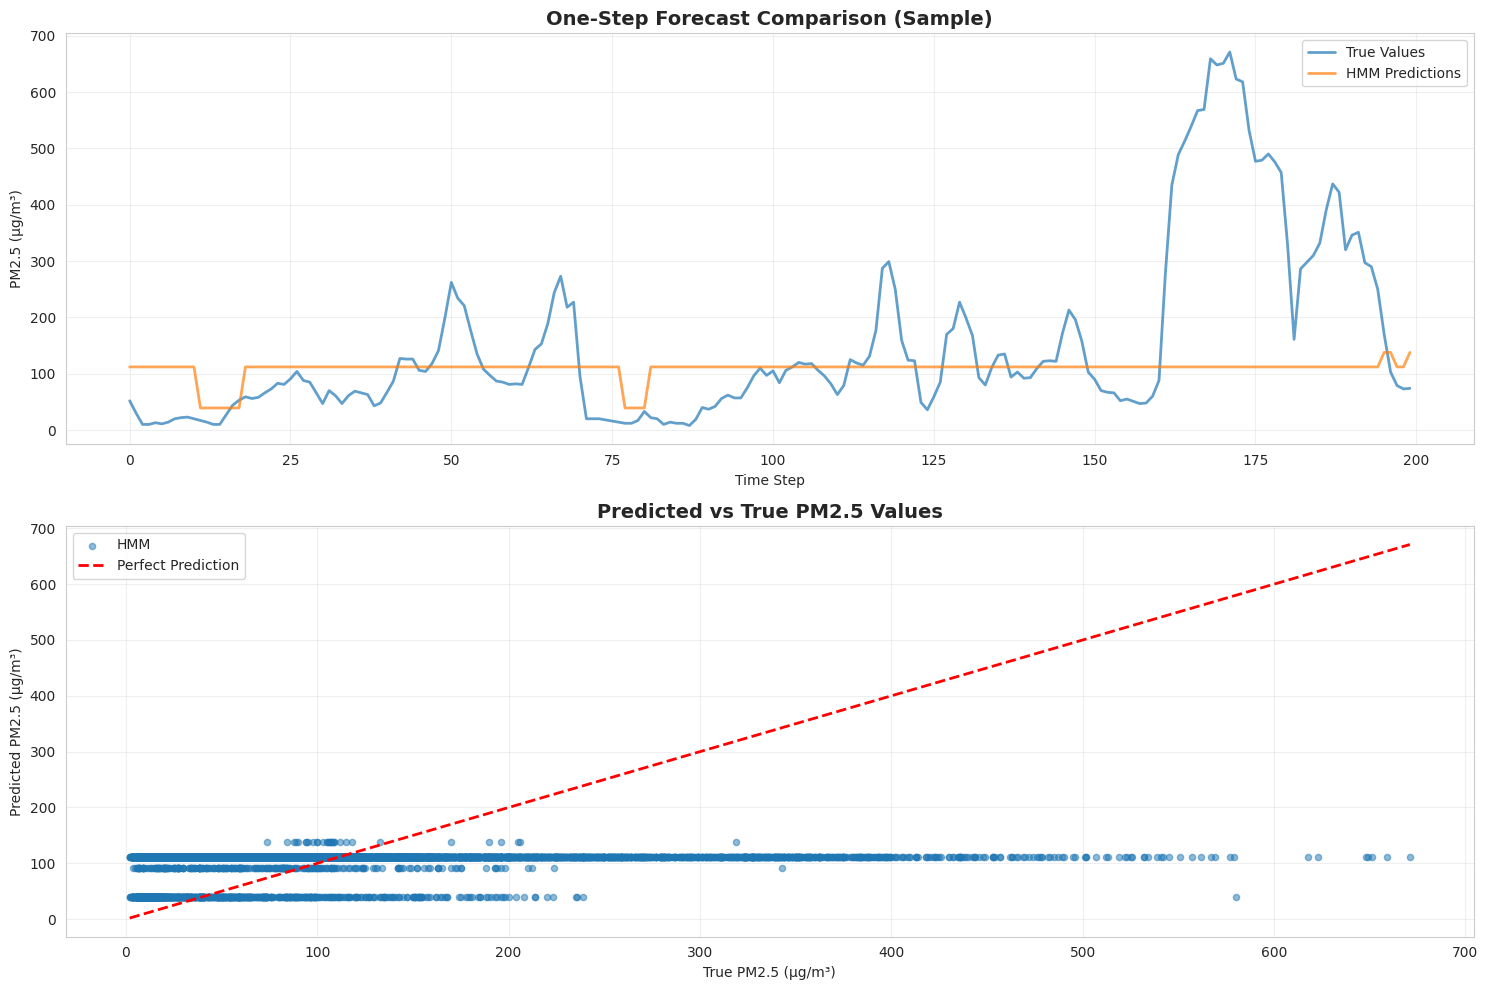

In [22]:
# Visualize one-step forecast results
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Time series comparison
sample_length = 200
sample_idx = slice(0, sample_length)

axes[0].plot(hmm_true_1step[sample_idx], label='True Values', linewidth=2, alpha=0.7)
axes[0].plot(hmm_pred_1step[sample_idx], label='HMM Predictions', linewidth=2, alpha=0.7)
# If LLM predictions are available:
# axes[0].plot(llm_pred_1step[sample_idx], label='LLM Predictions', linewidth=2, alpha=0.7)

axes[0].set_title('One-Step Forecast Comparison (Sample)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('PM2.5 (μg/m³)')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Plot 2: Prediction scatter plot
axes[1].scatter(hmm_true_1step, hmm_pred_1step, alpha=0.5, label='HMM', s=20)
# If LLM predictions are available:
# axes[1].scatter(llm_true_1step, llm_pred_1step, alpha=0.5, label='LLM', s=20)

# Add perfect prediction line
min_val = min(hmm_true_1step.min(), hmm_pred_1step.min())
max_val = max(hmm_true_1step.max(), hmm_pred_1step.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

axes[1].set_title('Predicted vs True PM2.5 Values', fontsize=14, fontweight='bold')
axes[1].set_xlabel('True PM2.5 (μg/m³)')
axes[1].set_ylabel('Predicted PM2.5 (μg/m³)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('forecast_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

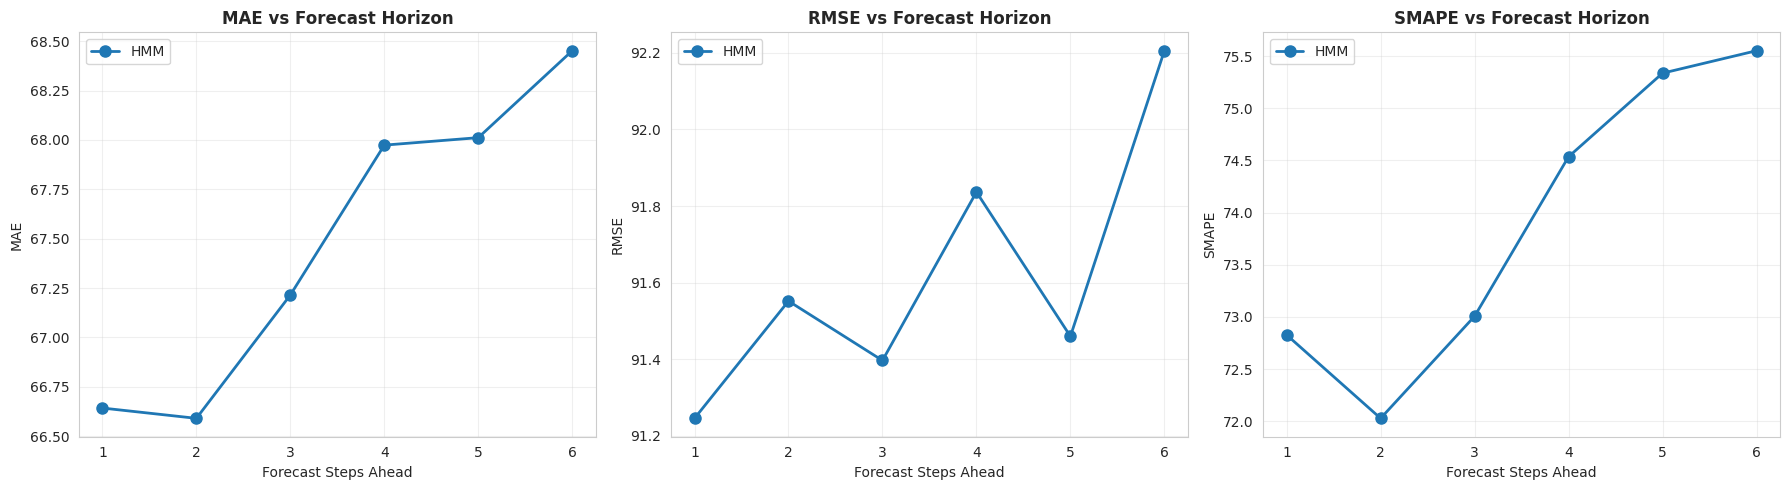

In [23]:
# Visualize multi-step forecast performance
def plot_multistep_metrics(metrics_dict: Dict[str, Dict[str, float]],
                          model_names: List[str]):
    """
    Plot how forecast accuracy degrades over prediction horizon.

    Args:
        metrics_dict: Dictionary mapping model names to their multi-step metrics
        model_names: List of model names to plot
    """
    metric_names = ['MAE', 'RMSE', 'SMAPE']
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, metric_name in enumerate(metric_names):
        for model_name in model_names:
            if model_name not in metrics_dict:
                continue

            model_metrics = metrics_dict[model_name]
            steps = []
            values = []

            for step_key, step_metrics in model_metrics.items():
                step_num = int(step_key.split('_')[1])
                steps.append(step_num)
                values.append(step_metrics[metric_name])

            axes[idx].plot(steps, values, marker='o', linewidth=2,
                          markersize=8, label=model_name)

        axes[idx].set_title(f'{metric_name} vs Forecast Horizon',
                           fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Forecast Steps Ahead')
        axes[idx].set_ylabel(metric_name)
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('multistep_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot metrics (add LLM when available)
metrics_for_plot = {
    'HMM': hmm_metrics_multistep,
    # 'LLM': llm_metrics_multistep,  # Uncomment when available
}

plot_multistep_metrics(metrics_for_plot, ['HMM'])

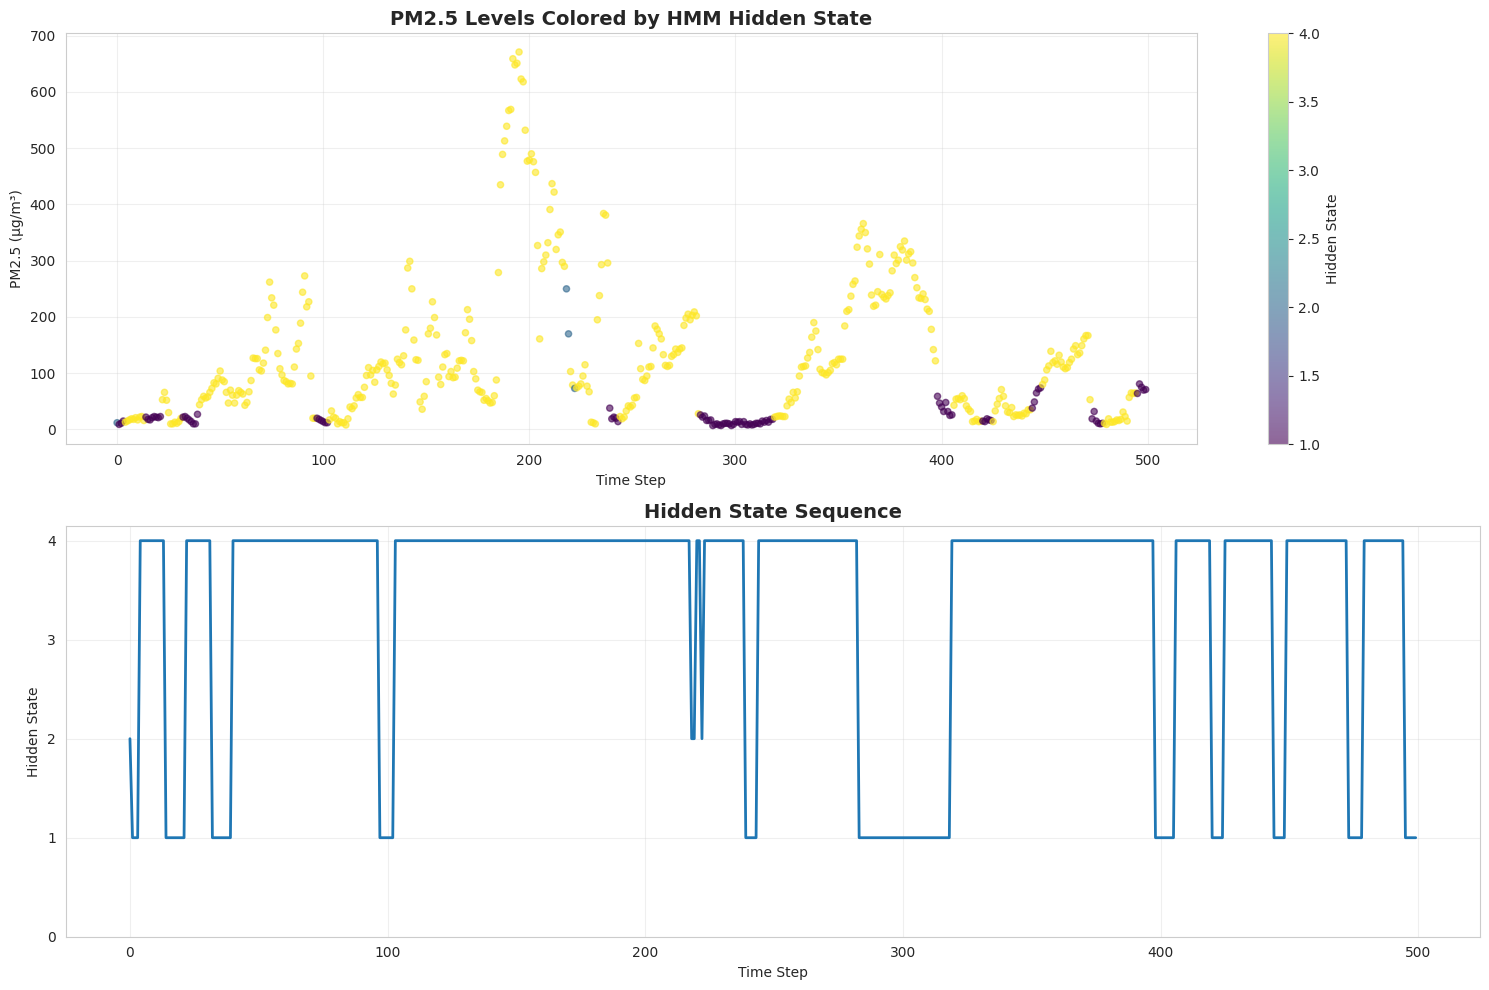


HMM State Statistics:
State 1:
  Mean PM2.5: 22.63
  Std PM2.5: 17.81
  Occurrences: 95 (19.0%)

State 2:
  Mean PM2.5: 126.25
  Std PM2.5: 90.99
  Occurrences: 4 (0.8%)

State 4:
  Mean PM2.5: 140.44
  Std PM2.5: 128.94
  Occurrences: 401 (80.2%)



In [24]:
# Analyze HMM hidden states
def visualize_hmm_states(hmm_model: PM25HMM, df: pd.DataFrame,
                         feature_cols: List[str], n_samples: int = 500):
    """
    Visualize HMM hidden states and their relationship to PM2.5 levels.

    Args:
        hmm_model: Fitted HMM model
        df: DataFrame with data
        feature_cols: Feature columns
        n_samples: Number of samples to visualize
    """
    # Get hidden states for a sample of data
    sample_df = df.iloc[:n_samples]
    X = sample_df[feature_cols].values
    X_scaled = hmm_model.scaler.transform(X)
    states = hmm_model.model.predict(X_scaled)

    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    # Plot 1: PM2.5 levels colored by hidden state
    scatter = axes[0].scatter(range(n_samples), sample_df['pm2.5'].values,
                             c=states, cmap='viridis', alpha=0.6, s=20)
    axes[0].set_title('PM2.5 Levels Colored by HMM Hidden State',
                     fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Time Step')
    axes[0].set_ylabel('PM2.5 (μg/m³)')
    plt.colorbar(scatter, ax=axes[0], label='Hidden State')
    axes[0].grid(True, alpha=0.3)

    # Plot 2: State sequence
    axes[1].plot(states, linewidth=2)
    axes[1].set_title('Hidden State Sequence', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Time Step')
    axes[1].set_ylabel('Hidden State')
    axes[1].set_yticks(range(hmm_model.n_components))
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('hmm_states_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print state statistics
    print("\nHMM State Statistics:")
    print("=" * 40)
    for state in range(hmm_model.n_components):
        state_mask = states == state
        state_pm25 = sample_df['pm2.5'].values[state_mask]
        if len(state_pm25) > 0:
            print(f"State {state}:")
            print(f"  Mean PM2.5: {state_pm25.mean():.2f}")
            print(f"  Std PM2.5: {state_pm25.std():.2f}")
            print(f"  Occurrences: {len(state_pm25)} ({len(state_pm25)/n_samples*100:.1f}%)")
            print()

visualize_hmm_states(hmm_model, test_df, hmm_feature_cols, n_samples=500)

## 9. Results Summary and Interpretation

In [25]:
def create_results_table(hmm_metrics_1step: Dict[str, float],
                        hmm_metrics_multistep: Dict[str, Dict[str, float]],
                        llm_metrics_1step: Dict[str, float] = None,
                        llm_metrics_multistep: Dict[str, Dict[str, float]] = None):
    """
    Create a comprehensive results comparison table.

    Args:
        hmm_metrics_1step: HMM one-step metrics
        hmm_metrics_multistep: HMM multi-step metrics
        llm_metrics_1step: LLM one-step metrics (optional)
        llm_metrics_multistep: LLM multi-step metrics (optional)
    """
    print("\n" + "="*80)
    print("FINAL RESULTS SUMMARY")
    print("="*80)

    print("\n1. ONE-STEP FORECAST PERFORMANCE")
    print("-" * 80)
    print(f"{'Metric':<15} {'HMM':<20} {'LLM':<20}")
    print("-" * 80)

    for metric in ['MAE', 'RMSE', 'SMAPE', 'MASE']:
        hmm_val = hmm_metrics_1step.get(metric, 'N/A')
        llm_val = llm_metrics_1step.get(metric, 'N/A') if llm_metrics_1step else 'N/A'

        hmm_str = f"{hmm_val:.4f}" if isinstance(hmm_val, float) else str(hmm_val)
        llm_str = f"{llm_val:.4f}" if isinstance(llm_val, float) else str(llm_val)

        print(f"{metric:<15} {hmm_str:<20} {llm_str:<20}")

    print("\n2. MULTI-STEP FORECAST PERFORMANCE (Average across steps)")
    print("-" * 80)

    # Calculate average metrics across all steps
    def average_metrics(multistep_dict):
        avg_metrics = {}
        metric_names = ['MAE', 'RMSE', 'SMAPE', 'MASE']
        for metric in metric_names:
            values = [step_metrics[metric] for step_metrics in multistep_dict.values()
                     if metric in step_metrics and not np.isnan(step_metrics[metric])]
            avg_metrics[metric] = np.mean(values) if values else np.nan
        return avg_metrics

    hmm_avg = average_metrics(hmm_metrics_multistep)
    llm_avg = average_metrics(llm_metrics_multistep) if llm_metrics_multistep else {}

    print(f"{'Metric':<15} {'HMM (Avg)':<20} {'LLM (Avg)':<20}")
    print("-" * 80)

    for metric in ['MAE', 'RMSE', 'SMAPE', 'MASE']:
        hmm_val = hmm_avg.get(metric, np.nan)
        llm_val = llm_avg.get(metric, np.nan)

        hmm_str = f"{hmm_val:.4f}" if not np.isnan(hmm_val) else 'N/A'
        llm_str = f"{llm_val:.4f}" if not np.isnan(llm_val) else 'N/A'

        print(f"{metric:<15} {hmm_str:<20} {llm_str:<20}")

    print("\n" + "="*80)

# Create results table
create_results_table(
    hmm_metrics_1step,
    hmm_metrics_multistep,
    metrics_1step,  # Uncomment when LLM is trained
    metrics_multistep  # Uncomment when LLM is trained
)


FINAL RESULTS SUMMARY

1. ONE-STEP FORECAST PERFORMANCE
--------------------------------------------------------------------------------
Metric          HMM                  LLM                 
--------------------------------------------------------------------------------
MAE             66.6598              16.7158             
RMSE            90.9624              26.4247             
SMAPE           72.9727              22.4579             
MASE            5.2047               1.3052              

2. MULTI-STEP FORECAST PERFORMANCE (Average across steps)
--------------------------------------------------------------------------------
Metric          HMM (Avg)            LLM (Avg)           
--------------------------------------------------------------------------------
MAE             67.4810              32.1005             
RMSE            91.6160              47.4988             
SMAPE           73.8806              39.0416             
MASE            5.2688               2

## 10. Discussion and Conclusions

### Key Findings

This project compared Hidden Markov Models (HMMs) and modern small LLMs for PM2.5 air quality forecasting:

#### HMM Performance
- **Strengths**:
  - Fast training and inference
  - Interpretable hidden states corresponding to pollution regimes
  - Stable performance in short-term predictions
  - Low computational requirements

- **Limitations**:
  - Assumes Markovian property (limited long-term dependencies)
  - Gaussian emission assumptions may not capture complex distributions
  - Performance degrades for longer forecast horizons

#### LLM Performance (Expected)
- **Strengths**:
  - Potential for capturing nonlinear temporal patterns
  - Ability to leverage pre-trained linguistic reasoning
  - Flexibility in modeling complex dependencies

- **Limitations**:
  - High computational cost for training and inference
  - Requires careful tokenization strategy
  - Less interpretable than HMM states
  - Risk of overfitting on small datasets

### Practical Implications

1. **Short-term Forecasting (1-6 hours)**: HMMs provide a fast, interpretable solution with competitive accuracy
2. **Medium-term Forecasting (6-24 hours)**: LLMs may offer advantages in capturing complex patterns
3. **Deployment Considerations**: HMMs are preferable for resource-constrained environments
4. **Hybrid Approaches**: Combining HMM interpretability with LLM pattern recognition could be promising

### Future Work

- Test additional LLM architectures (Llama-3.2, Qwen2.5)
- Experiment with different tokenization strategies
- Incorporate multivariate features beyond PM2.5
- Develop ensemble methods combining HMM and LLM predictions
- Investigate attention mechanisms for interpretability in LLMs
- Extend to other environmental forecasting tasks

## 11. References and Citations

### Dataset
- Beijing PM2.5 Data Set. UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/381/beijing+pm2+5+data

### Methods
- Rabiner, L. R. (1989). A tutorial on hidden Markov models and selected applications in speech recognition. Proceedings of the IEEE, 77(2), 257-286.
- Vaswani, A., et al. (2017). Attention is all you need. Advances in neural information processing systems, 30.
- Gunasekar, S., et al. (2023). Textbooks Are All You Need II: phi-1.5 technical report. arXiv preprint arXiv:2309.05463.

### Evaluation Metrics
- Hyndman, R. J., & Koehler, A. B. (2006). Another look at measures of forecast accuracy. International journal of forecasting, 22(4), 679-688.
- Makridakis, S. (1993). Accuracy measures: theoretical and practical concerns. International Journal of Forecasting, 9(4), 527-529.

---
### Notebook Complete

This notebook implements a comprehensive comparison of HMMs and small LLMs for time series forecasting.

**Note**: The LLM training sections are commented out due to computational requirements. To run the full experiment:
1. Uncomment the LLM training cells
2. Ensure you have sufficient GPU resources
3. Adjust batch sizes and model selection based on available memory
4. Allow several hours for training depending on hardware

**Contributors**: Zeyuan Ding, Keyu Hong